---
# Imports

In [2]:
# plotting libraries
import seaborn as sns
sns.set_theme()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import spacy
from spacy import displacy
from collections import Counter

from utils.utils import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---
# 0. Exploratory Data Analysis (EDA)

## STEP 1 - Dataset import

In [3]:
### Load file --------------------------------------------
df = pd.read_csv('./../data/all-data.csv', sep = ",",encoding='ISO-8859-1')
df.head()

,Y,Notices
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


## STEP 2 - Droping null values

Since our dataset has only two columns, the label and the text. If we have any null values in any of the columns that row is not going to give any information, so we can drop it.

In [4]:
# Eliminar duplicados y filas con valores nulos
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
print("Shape of the dataset after dropping the null values:", df.shape)

Shape of the dataset after dropping the null values: (4840, 2)


Since we are going to do diffent things with the dataset (use different tokenization, group the documents by their classes) for different methods, instead of cleaning and tokenizing the data here, we are going to apply it in each implementation, to have more flexibility in the code.

## STEP 3 - Sentiment class distribution

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12456\3592097192.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


Distribución de clases de sentimiento:
Y
neutral     2873
positive    1363
negative     604
Name: count, dtype: int64


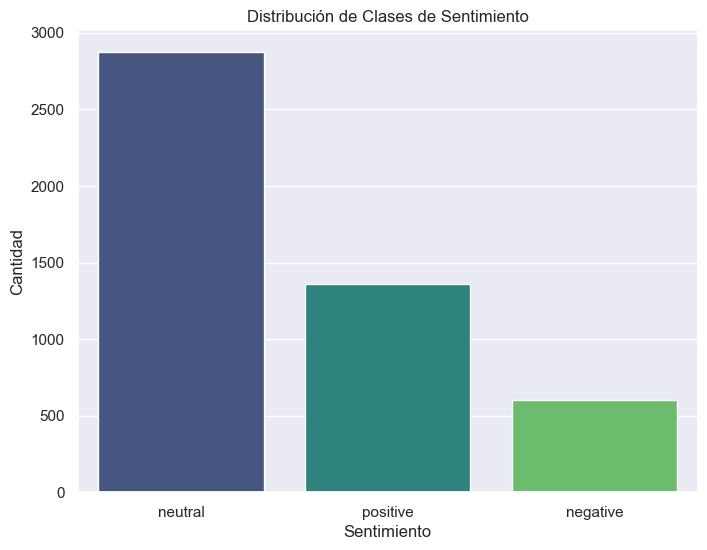

In [5]:
# Contar las ocurrencias de cada clase en la columna "Y"
sentiment_counts = df['Y'].value_counts()
print("Distribución de clases de sentimiento:")
print(sentiment_counts)

# Visualizar la distribución con un gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title("Distribución de Clases de Sentimiento")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad")
plt.show()

## STEP 4 - Analysis word most frequent from category

In [6]:
sentiment_categories = df['Y'].unique()

# Iterar por cada categoría de sentimiento
for sentiment in sentiment_categories:
    # Filtrar las filas que correspondan a la categoría actual
    subset = df[df['Y'] == sentiment]
    # Concatenar todos los textos
    all_text = " ".join(subset['Notices'].tolist())
    # Preprocesar el texto
    tokens = preprocess_text(all_text)
    # Contar la frecuencia de cada palabra
    counter = Counter(tokens)
    most_common = counter.most_common(10)
    print(f"\nPalabras más frecuentes para el sentimiento '{sentiment}':")
    for word, count in most_common:
        print(f"{word}: {count}")


Palabras más frecuentes para el sentimiento 'neutral':
company: 506
eur: 315
said: 237
finland: 218
finnish: 215
million: 193
business: 190
group: 184
new: 179
sales: 163

Palabras más frecuentes para el sentimiento 'negative':
eur: 400
mn: 237
profit: 156
net: 104
company: 100
finnish: 99
sales: 98
operating: 97
period: 88
quarter: 79

Palabras más frecuentes para el sentimiento 'positive':
eur: 595
mn: 262
company: 240
said: 230
finnish: 198
net: 196
sales: 192
profit: 191
million: 170
year: 143


In [7]:
# Lets do it with the other preprocessing function that keeps the info that the number give us by compacting the information (see the
# utils.py file where is documented if interested): 

sentiment_categories = df['Y'].unique()

# Iterar por cada categoría de sentimiento
for sentiment in sentiment_categories:
    # Filtrar las filas que correspondan a la categoría actual
    subset = df[df['Y'] == sentiment]
    # Concatenar todos los textos
    all_text = " ".join(subset['Notices'].tolist())
    # Preprocesar el texto
    tokens = preprocess_text_nums(all_text)
    # Contar la frecuencia de cada palabra
    counter = Counter(tokens)
    most_common = counter.most_common(10)
    print(f"\nPalabras más frecuentes para el sentimiento '{sentiment}':")
    for word, count in most_common:
        print(f"{word}: {count}")

    # Specifically look at number categories
    number_categories = ['HIGHNUMBER', 'MEDIUMNUMBER', 'LOWNUMBER', 'VERYLOWNUMBER', 'EXTREMELYLOWNUMBER', 'MINIMALNUMBER']
    print(f"\nFrecuencia de categorías numéricas para el sentimiento '{sentiment}':")
    for category in number_categories:
        count = counter[category]
        print(f"{category}: {count}")


Palabras más frecuentes para el sentimiento 'neutral':
EXTREMELYLOWNUMBER: 1173
MEDIUMNUMBER: 1064
VERYLOWNUMBER: 680
company: 508
MINIMALNUMBER: 451
eur: 359
said: 238
LOWNUMBER: 230
finland: 227
HIGHNUMBER: 224

Frecuencia de categorías numéricas para el sentimiento 'neutral':
HIGHNUMBER: 224
MEDIUMNUMBER: 1064
LOWNUMBER: 230
VERYLOWNUMBER: 680
EXTREMELYLOWNUMBER: 1173
MINIMALNUMBER: 451

Palabras más frecuentes para el sentimiento 'negative':
EXTREMELYLOWNUMBER: 663
MEDIUMNUMBER: 453
eur: 417
VERYLOWNUMBER: 331
mn: 237
MINIMALNUMBER: 164
profit: 156
net: 104
finnish: 102
company: 100

Frecuencia de categorías numéricas para el sentimiento 'negative':
HIGHNUMBER: 62
MEDIUMNUMBER: 453
LOWNUMBER: 75
VERYLOWNUMBER: 331
EXTREMELYLOWNUMBER: 663
MINIMALNUMBER: 164

Palabras más frecuentes para el sentimiento 'positive':
EXTREMELYLOWNUMBER: 1018
MEDIUMNUMBER: 791
eur: 639
VERYLOWNUMBER: 538
MINIMALNUMBER: 399
mn: 264
company: 241
said: 230
year: 212
finnish: 202

Frecuencia de categorías n

## STEP 5 - Word Cloud for each category

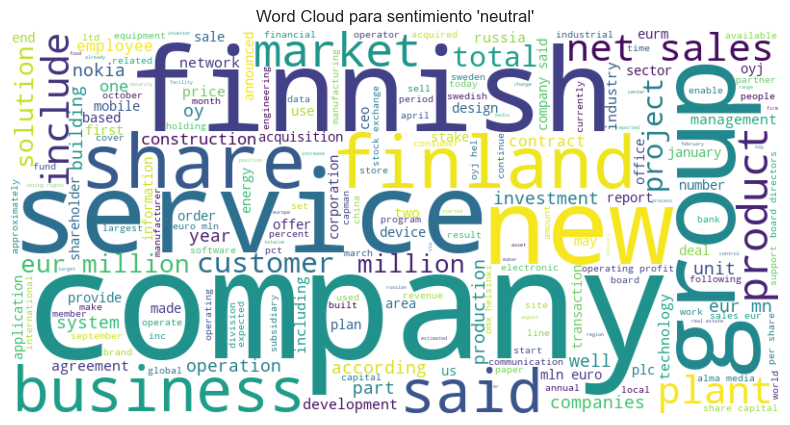

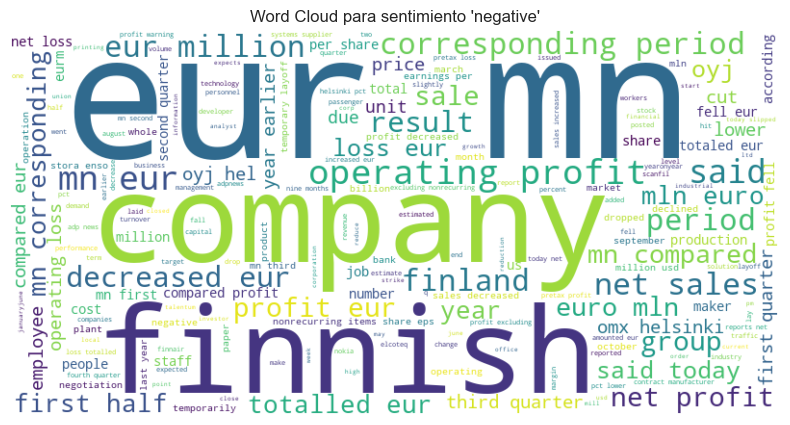

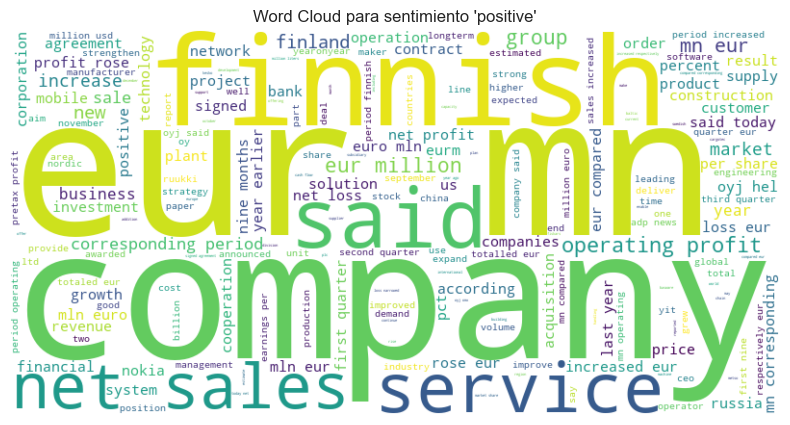

In [8]:
for sentiment in sentiment_categories:
    subset = df[df['Y'] == sentiment]
    all_text = " ".join(subset['Notices'].tolist())
    tokens = preprocess_text(all_text)
    # Reconstruir el texto a partir de tokens preprocesados
    text_processed = " ".join(tokens)
    
    # Generar la nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_processed)
    
    # Visualizar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud para sentimiento '{sentiment}'")
    plt.show()

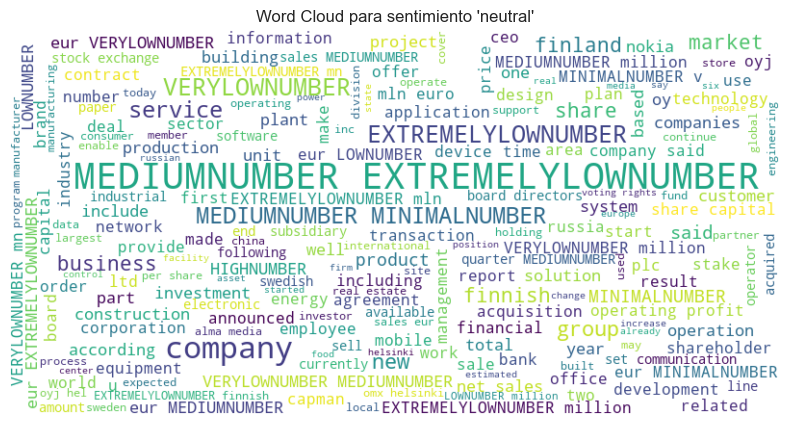

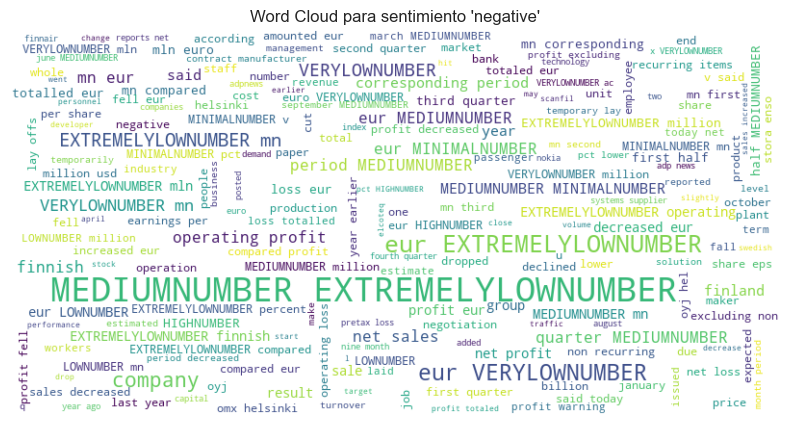

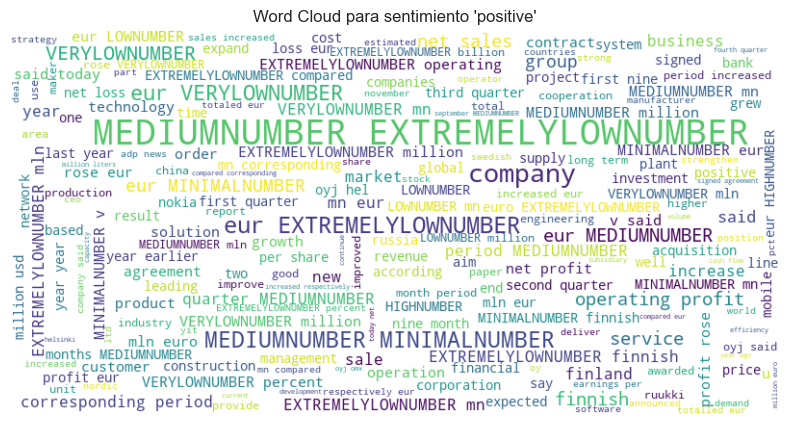

In [9]:
# Lets do it with the other preprocessing function that keeps the info that the number give us by compacting the information (see the
# utils.py file where is documented if interested):

for sentiment in sentiment_categories:
    subset = df[df['Y'] == sentiment]
    all_text = " ".join(subset['Notices'].tolist())
    tokens = preprocess_text_nums(all_text)
    # Reconstruir el texto a partir de tokens preprocesados
    text_processed = " ".join(tokens)
    
    # Generar la nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_processed)
    
    # Visualizar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud para sentimiento '{sentiment}'")
    plt.show()

As we can see it is better to keep the numbers off the wordcloud to be able to see something.

---
# 1. Extras

## 1.1. NER 

We've seen that most of the phases are about the finnish economy or deals related somehow to Finland. Now we are going to apply Named entity recognition to see what other entities are talked about. We are going to use spacy for this task, we are going to use the small language model as well the medium language model (from spacy) and compare the results while we are on it. For this is necessary to import both language models for english, put in the console :

`python -m spacy download en_core_web_sm`

`python -m spacy download en_core_web_md`

The small model (en_core_web_sm) is lightweight and optimized for speed, making it efficient for basic NER tasks. However, it lacks word vectors and relies on feature-based rules and statistical predictions, leading to lower accuracy in complex cases.

The medium model (en_core_web_md) includes pretrained word vectors, enhancing its ability to capture semantic relationships and improving entity recognition performance. It has a larger vocabulary and more robust feature representations, resulting in higher accuracy but requiring more memory and processing power.

We are getting ahead of ourselves here because the medium model that we are going to use for NER uses pretrained embeddings, but we are going to see that for a simple problem like this the simpler model does not perform that bad and its a lot simpler and cheaper (for computation).

Here we have made a list of all the categories spacy separates the entities:

| **Label**      | **Meaning**                                        | **Example**                                |
|--------------|-------------------------------------------------|--------------------------------------------|
| **PERSON**    | People, including fictional characters          | _Elon Musk_, _Lionel Messi_                |
| **NORP**      | Nationalities, religious or political groups    | _Mexican_, _Buddhist_, _Democrats_        |
| **FAC**       | Facilities, buildings, airports, bridges, etc.  | _Eiffel Tower_, _Wall Street_              |
| **ORG**       | Organizations, companies, agencies, institutions | _Google_, _NASA_, _United Nations_         |
| **GPE**       | Geopolitical entities (countries, cities, states) | _Argentina_, _New York_, _Germany_         |
| **LOC**       | Physical locations (mountains, rivers, regions) | _Amazon River_, _Mount Everest_, _Sahara Desert_ |
| **PRODUCT**   | Objects, vehicles, devices, food products       | _iPhone_, _Tesla Model S_, _PlayStation 5_ |
| **EVENT**     | Historical or cultural events                   | _World War II_, _Olympics 2024_            |
| **WORK_OF_ART** | Titles of books, movies, songs, paintings      | _The Mona Lisa_, _Harry Potter_, _Bohemian Rhapsody_ |
| **LAW**       | Legal documents, laws, regulations              | _Constitution_, _GDPR_, _Magna Carta_      |
| **LANGUAGE**  | Names of languages                              | _English_, _Spanish_, _Mandarin_          |
| **DATE**      | Absolute dates, years, periods                 | _March 2nd, 2025_, _2020_                  |
| **TIME**      | Specific times of day                          | _10:30 AM_, _Midnight_                     |
| **PERCENT**   | Percentage expressions                         | _50%_, _12.5%_                            |
| **MONEY**     | Monetary values                                | _$100_, _€50M_, _10,000 yen_              |
| **QUANTITY**  | General measurable amounts (not money)         | _five liters_, _two dozen_                 |
| **ORDINAL**   | Ranking positions or order                     | _First_, _2nd_, _third_                    |
| **CARDINAL**  | Numbers, numerical counts                      | _One_, _1000_, _five million_              |

---

this is an example of how spacy is used:

```python
import spacy

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# Sample text
text = "Elon Musk, the CEO of Tesla, was born in South Africa and now lives in the United States."

# Process the text
doc = nlp(text)

# Print extracted entities
for ent in doc.ents:
    print(f"{ent.text} → {ent.label_} ({spacy.explain(ent.label_)})")


In [10]:
# Load both models
nlp_sm = spacy.load("en_core_web_sm")  # Small model
nlp_md = spacy.load("en_core_web_md")  # Medium model

# First, using the whole corpus:
all_text = " ".join(df['Notices'].tolist())
tokens = preprocess_text(all_text)
# Reconstruir el texto a partir de tokens preprocesados
text_processed = " ".join(tokens)

entities_sm = extract_entities(text_processed, nlp_sm)
print(f"Entities of the whole corpus (SM): {entities_sm}")

entities_md = extract_entities(text_processed, nlp_md)
print(f"Entities of the whole corpus (MD): {entities_md}")

# Now we are going to see what are the most talked about entities:

# We want to know these 6 categories in particular because we deem them important (we don't include money because its just going to say a random 
# number):
target_labels = {"PERSON", "NORP", "ORG", "GPE", "LOC", "PRODUCT"}

top_entities_sm = extract_most_frequent_entities(entities_sm, target_labels)
print("\n🔹 Most Frequent Entities (SM Model):")
for entity, count in top_entities_sm:
    print(f"{entity}: {count} occurrences")

top_entities_md = extract_most_frequent_entities(entities_md, target_labels)
print("\n🔹 Most Frequent Entities (MD Model):")
for entity, count in top_entities_md:
    print(f"{entity}: {count} occurrences")

print(f'Number of entities with the small model: {len(entities_sm)}')
print(f'Number of entities with the medium model: {len(entities_md)}')

Entities of the whole corpus (SM): [('russia', 'GPE'), ('less square meters', 'QUANTITY'), ('tens', 'CARDINAL'), ('daily', 'DATE'), ('last quarter', 'DATE'), ('period year earlier', 'DATE'), ('zero', 'CARDINAL'), ('third quarter', 'DATE'), ('stora enso', 'PERSON'), ('norske skog mreal', 'PERSON'), ('suisse first boston', 'ORG'), ('four', 'CARDINAL'), ('tons gasoline', 'PERSON'), ('delivery hamina', 'PERSON'), ('finland', 'GPE'), ('september', 'DATE'), ('eight us dollars', 'MONEY'), ('prior year', 'DATE'), ('nokia', 'ORG'), ('nokian', 'NORP'), ('fourthquarter', 'DATE'), ('days', 'DATE'), ('russian', 'NORP'), ('today', 'DATE'), ('million', 'CARDINAL'), ('december', 'DATE'), ('ninemonth', 'ORDINAL'), ('ninemonth', 'ORDINAL'), ('brazilian', 'NORP'), ('last year', 'DATE'), ('vladimir brando', 'PERSON'), ('year million', 'CARDINAL'), ('million', 'CARDINAL'), ('year', 'DATE'), ('million', 'CARDINAL'), ('january', 'DATE'), ('february', 'DATE'), ('hel saav', 'PERSON'), ('yesterday', 'DATE'), ('

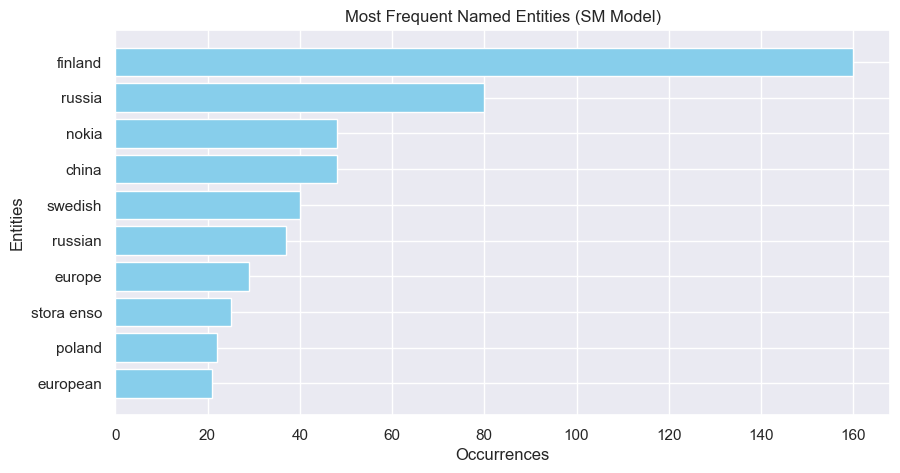

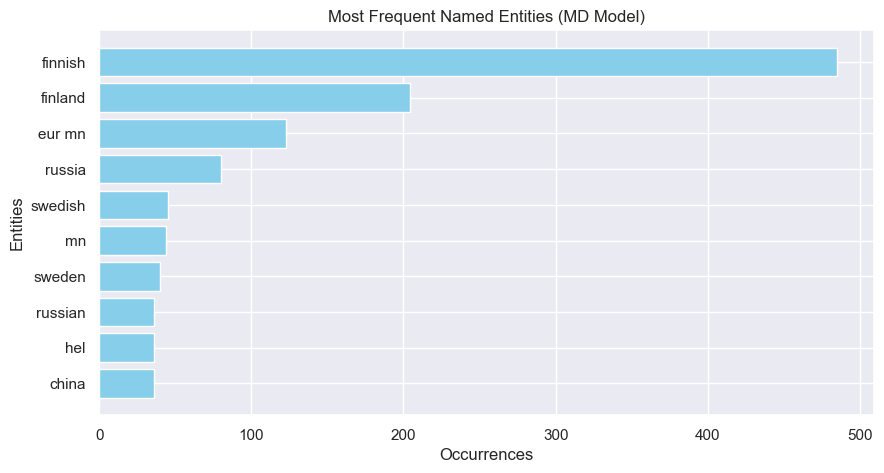

In [11]:
# Plot results
plot_entity_frequencies(top_entities_sm, "SM Model")
plot_entity_frequencies(top_entities_md, "MD Model")

The medium model detected 6681 entities, compared to 4501 entities with the small model. This aligns with expectations, as en_core_web_md has pretrained word vectors, enabling it to recognize a broader range of entities.

One notable finding is that the medium model does not list 'Nokia' among the most frequent entities like the small model does. Upon further inspection, we saw that Nokia has a lot of names across the corpus ('partnership nokia siemens networks', 'nokia corp', 'eur mn nokia', 'nokia intellisync mobile suite' ...) and the model captures this modifications as it should, but in a exploratory context we could argue that the smaller one give us a better summary. 

In conclusion, from a exploratory perspective we think that the smaller model its better since its faster, cheaper and its more useful for quick insights and summarization (in this case) because it tends to collapse entity variations into a single term. For better accuracy we would use the bigger model . 

In the future for each of the headlines/statements we will do a NER to know the companies/countries/products/... it refers to so we knoe what part of the market it is going to go down in value.

## 1.2. TF-IDF

Besides the entities that are mentioned in the corpus, we also want to know what words are more characteristic for each category, not the most recurrent words, but the most important/characteristic ones. This differs from a simple count of the words, as we did earlier in the world cloud. Now, we are going to use TF-IDF, which accounts for inverse document frequency, allowing us to assign greater importance to less frequent words in the corpus.

In [12]:
basic_top_tfidf_terms(df)

{'neutral': [('extremelylownumber', 0.042112476455728944),
  ('mediumnumber', 0.03951894909621577),
  ('verylownumber', 0.02815729354500889),
  ('company', 0.02443502258364663),
  ('minimalnumber', 0.020393968179365195),
  ('eur', 0.020076883500364635),
  ('highnumber', 0.01460437960526115),
  ('finland', 0.013666608745689389),
  ('million', 0.013605568745527074),
  ('lownumber', 0.013030753059215734),
  ('business', 0.012313711093602235),
  ('said', 0.01187253421496263),
  ('new', 0.011494934007713424),
  ('shares', 0.011388112501671693),
  ('group', 0.011154383362479493),
  ('sales', 0.011044633818491936),
  ('finnish', 0.010446272334361307),
  ('also', 0.010290116272323555),
  ('share', 0.010162227191594243),
  ('value', 0.009984033491909976)],
 'negative': [('extremelylownumber', 0.1143920078605612),
  ('eur', 0.10230290905688404),
  ('mn', 0.08293341144661973),
  ('mediumnumber', 0.07967762659785066),
  ('verylownumber', 0.06866577255672289),
  ('profit', 0.04889401567091709),
  (

The first thing we see is that the numbers are the most weighted in the three classes (probably due to the very high frecuency in which they are found, even with the IDF term weighting them down they are present in too many documents), this is telling us that the numbers do not matter as much as we thought, since both high numbers and very low numbers are present in each category. We also can see that, apart from the numbers, the tf-idf worked well, in the positive classes we have words like increased and rose, in the negative other words like fell or decreased are used. The word profit is used in both positive and negative documents, to capture if is good or bad we will need more advanced techniques that can capture semantic meaning like embeddings.

Not loosing  focus of our objective, that is finding the most important words for each class, we are going to merge some documents from each class to see if having bigger documents would help the TF-IDF method, we are also going to try merging all the documents for each class and thejn applying TF-IDF but we suspect that this is going to be a lot close to the wordcloud since the inverse term frecuency its not going to vary very much:

Top terms from merged chunks:

Sentiment: 'neutral'
verylownumber: 0.0570
company: 0.0462
minimalnumber: 0.0430
eur: 0.0352
highnumber: 0.0311
finland: 0.0283
lownumber: 0.0282
business: 0.0281
shares: 0.0279
new: 0.0274
million: 0.0262
said: 0.0251
group: 0.0245
finnish: 0.0237
services: 0.0234
also: 0.0220
market: 0.0216
share: 0.0215
sales: 0.0201
total: 0.0185

Sentiment: 'negative'
eur: 0.1931
mn: 0.1588
verylownumber: 0.1333
profit: 0.1046
decreased: 0.0805
minimalnumber: 0.0752
period: 0.0707
operating: 0.0676
quarter: 0.0666
year: 0.0663
compared: 0.0655
net: 0.0641
loss: 0.0626
mln: 0.0620
fell: 0.0572
sales: 0.0571
finnish: 0.0529
million: 0.0502
first: 0.0491
lownumber: 0.0455

Sentiment: 'positive'
eur: 0.1284
verylownumber: 0.0925
minimalnumber: 0.0800
mn: 0.0773
year: 0.0607
profit: 0.0555
net: 0.0519
said: 0.0500
mln: 0.0487
sales: 0.0483
million: 0.0469
period: 0.0454
finnish: 0.0452
company: 0.0452
rose: 0.0427
increased: 0.0393
quarter: 0.0376
operating: 0.0369
lownum

c:\MBD_Repos\Assigment_no_estructurados\code\utils\utils.py:337: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf', y='term', data=terms_df, palette='viridis')
c:\MBD_Repos\Assigment_no_estructurados\code\utils\utils.py:337: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf', y='term', data=terms_df, palette='viridis')
c:\MBD_Repos\Assigment_no_estructurados\code\utils\utils.py:337: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf', y='term', data=terms_df, palette='viridis')


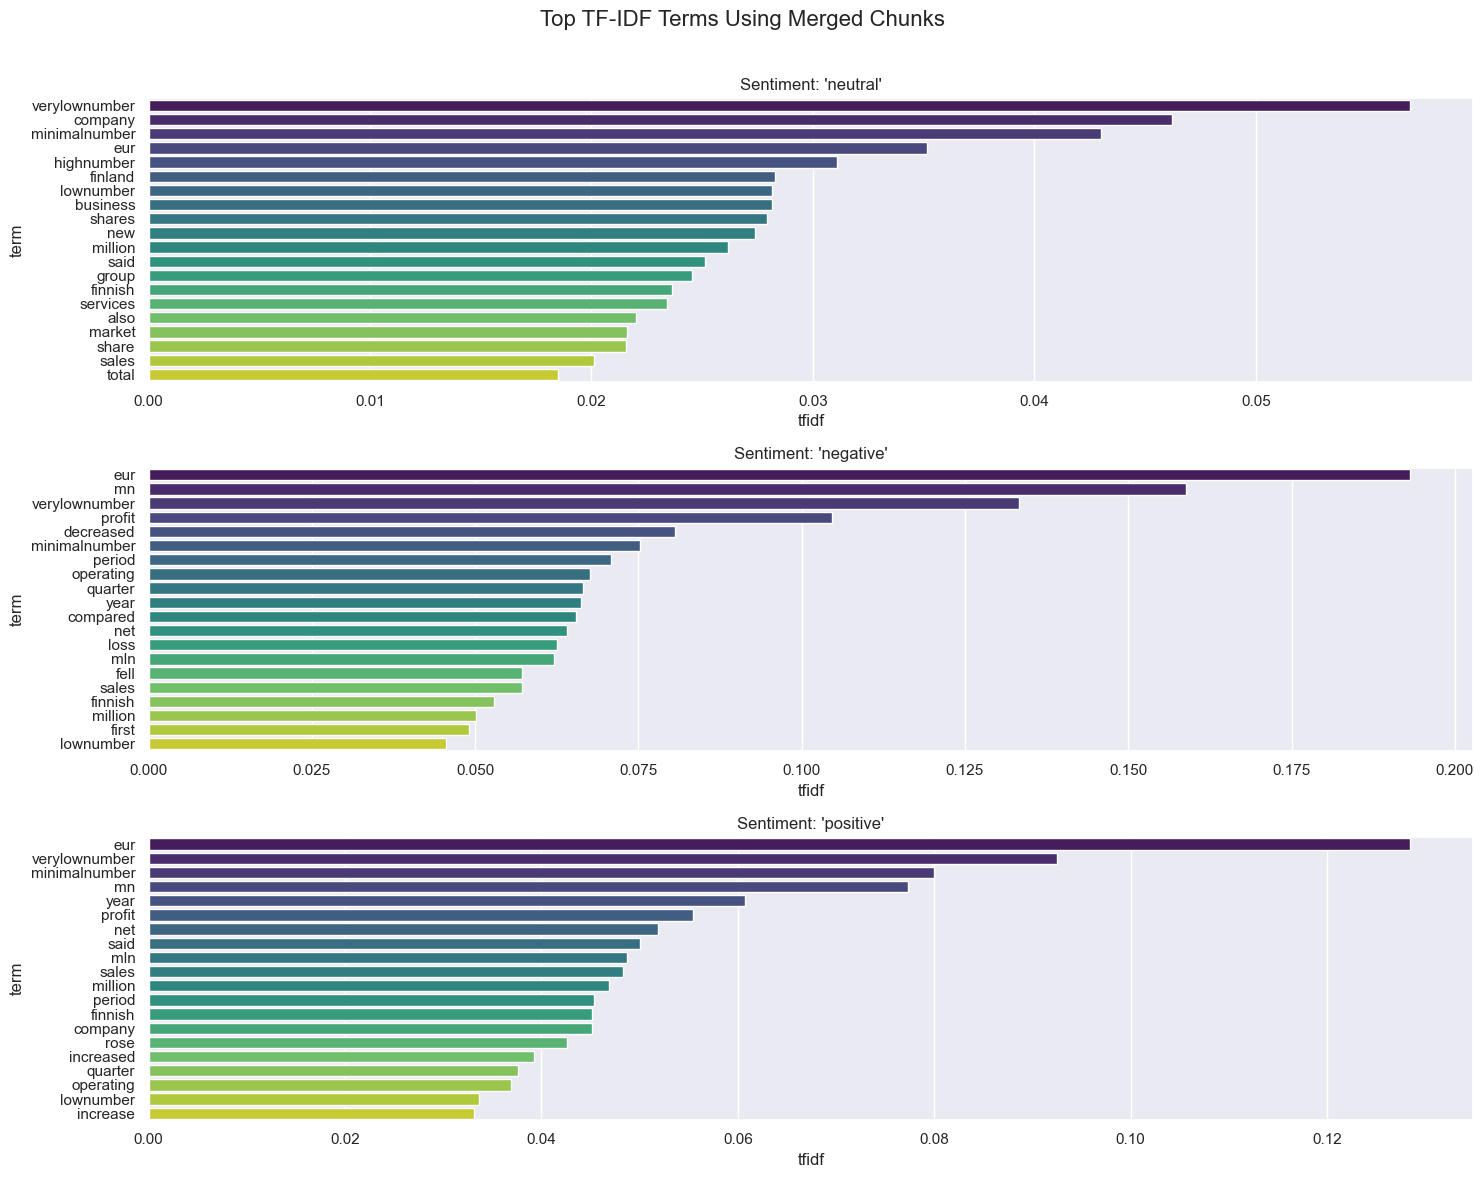

c:\MBD_Repos\Assigment_no_estructurados\code\utils\utils.py:353: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf', y='term', data=terms_df, palette='viridis')
c:\MBD_Repos\Assigment_no_estructurados\code\utils\utils.py:353: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf', y='term', data=terms_df, palette='viridis')
c:\MBD_Repos\Assigment_no_estructurados\code\utils\utils.py:353: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf', y='term', data=terms_df, palette='viridis')


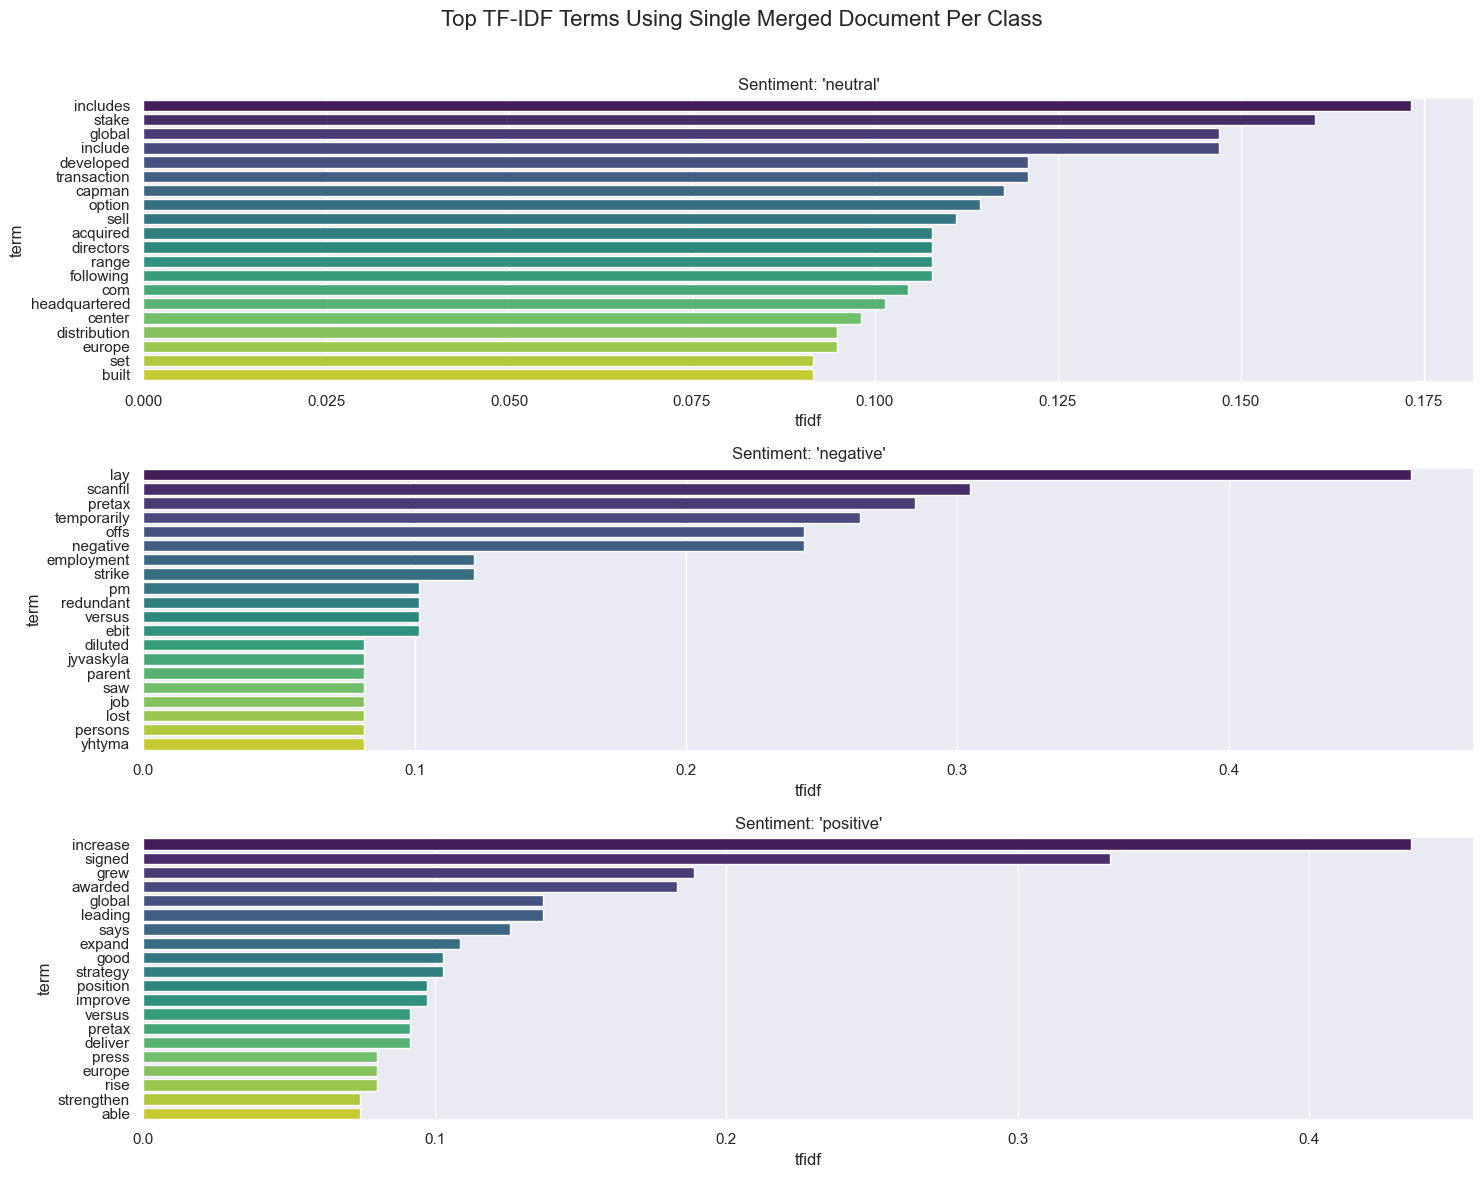

In [13]:
top_terms_chunks, top_terms_single = run_tfidf_analysis(df, column='Notices', label_column='Y', n_terms=20)

# Print results
print("Top terms from merged chunks:")
for sentiment, terms in top_terms_chunks.items():
    print(f"\nSentiment: '{sentiment}'")
    for term, score in terms:
        print(f"{term}: {score:.4f}")

print("\n\nTop terms from single merged document per class:")
for sentiment, terms in top_terms_single.items():
    print(f"\nSentiment: '{sentiment}'")
    for term, score in terms:
        print(f"{term}: {score:.4f}")
# 
# Visualize results
visualize_results(top_terms_chunks, top_terms_single)

We can see that the best results are the ones given by merging all the documents of each class and aplying TF-IDF to those three documents. Is better because it gave us some words that did not appear before that make a lot of sense like strike for negative or rise for positive.

Later in the project we are going to use TF-IDF, not only to explore the dataset, but in a way to vectorise the documents so we can feed the  information to a machine learning model.

---
# 2: Simple Methods (Baseline Models)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

## 2.1 Bag-of-Words (BoW) + Clasificador

The Bag-of-Words model is a foundational text representation technique that converts documents into numerical feature vectors based on word frequencies. In a BoW representation, each document is reduced to a “bag” of its words, disregarding grammar and word order. The result is usually a sparse vector where each dimension corresponds to a vocabulary term and the value is the count of that term in the document​. BoW is widely used as a baseline method in text classification, including financial sentiment analysis, due to its simplicity and effectiveness​.

In [15]:
# Dividir el dataset en entrenamiento y prueba
X = df['Notices']
y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir el texto a una matriz de frecuencias usando CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

### 2.1.1. Clasificador Naïve Bayes

- It calculates the probability of a document belonging to a particular class based on the frequencies of the words appearing in the csv.
- The “naïve” assumption simplifies computations by treating each feature as independent from the others, which significantly speeds up training and inference.
- The hyperparameter alpha helps deal with zero-frequency issues. In our results, alpha=1.0 indicates simple additive smoothing, which tends to work well in many text classification scenarios.

In [16]:
param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 2.0]}
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=10, n_jobs=-1)
grid_nb.fit(X_train_bow, y_train)
y_pred_nb = grid_nb.predict(X_test_bow)

print("Desempeño del Clasificador Naïve Bayes:")
print("Mejores parámetros:", grid_nb.best_params_)
print("\nAccuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Desempeño del Clasificador Naïve Bayes:
Mejores parámetros: {'alpha': 1.0}

Accuracy: 0.7107438016528925
              precision    recall  f1-score   support

    negative       0.62      0.42      0.51       118
     neutral       0.77      0.86      0.81       563
    positive       0.60      0.54      0.57       287

    accuracy                           0.71       968
   macro avg       0.66      0.61      0.63       968
weighted avg       0.70      0.71      0.70       968



The classifier performs well on the neutral class, which likely has more training examples or more distinct vocabulary. The negative class shows room for improvement, especially in recall. It might help to gather more negative-labeled samples or explore techniques like class-weighting or more advanced feature engineering. 

This result is typical for a first-pass Bag-of-Words approach with Naïve Bayes: it’s quick to train, often yields a decent starting accuracy, and provides a useful baseline to compare against more complex or fine-tuned models later on.

### 2.1.2. Clasificador Logistic Regression

- Each word in the vocabulary is assigned a weight indicating how strongly it influences the sentiment (negative, neutral, or positive).
- By using the regularization parameter C, the model prevents overfitting by limiting the magnitude of these weights.
- The penalty 'l2' ensures that large coefficients are penalized, which often leads to more robust performance in text classification.


In [17]:
param_grid_lr = {'C': [0.1, 1, 10, 100], 'penalty': ['l2']}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=10, n_jobs=-1)
grid_lr.fit(X_train_bow, y_train)
y_pred_lr = grid_lr.predict(X_test_bow)


print("Desempeño del Clasificador Logistic Regression:")
print("Mejores parámetros:", grid_lr.best_params_)
print("\nAccuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Desempeño del Clasificador Logistic Regression:
Mejores parámetros: {'C': 1, 'penalty': 'l2'}

Accuracy: 0.734504132231405
              precision    recall  f1-score   support

    negative       0.73      0.47      0.57       118
     neutral       0.75      0.90      0.82       563
    positive       0.69      0.53      0.60       287

    accuracy                           0.73       968
   macro avg       0.72      0.63      0.66       968
weighted avg       0.73      0.73      0.72       968



The classifier performs well on the neutral class, which likely has more training examples or a more distinct vocabulary, allowing it to stand out more clearly in the dataset. The negative class shows higher precision but lower recall, indicating that while the model is fairly accurate when it does predict negative, it misses several actual negative cases. The model also struggles somewhat with the positive class, suggesting that additional data or more advanced techniques may be required to capture subtle indicators of positive sentiment.

Overall, this is a typical outcome for a first-pass Bag-of-Words approach with Logistic Regression: it provides a strong, easily interpretable baseline, but further optimization can often boost performance on minority sentiment classes.

---
# 3: Intermediate Models (Machine Learning & Topic Modeling)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

## 3.1 TF-IDF + Machine Learning Models

In [19]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(df['Notices'])
y = df['Y']

# Separar en train y test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

### 3.1.1 SVM

- Effective in High Dimensions: SVM can handle thousands of TF-IDF features, finding a hyperplane that separates positive vs. negative vs.neutral sentiment with maximal margin. This often leads to strong generalization on unseen financial texts​. Studies on financial news have found SVM to achieve top accuracy among classifiers​, indicating its robustness for this task.

- Balanced Precision-Recall: By maximizing the margin, SVM tends to avoid overfitting and often yields high precision (fewer false positives) without sacrificing much recall. In practice, TF-IDF + SVM often achieves a high F1-score, showing it captures sentiment-bearing words effectively.

- Well-Established Baseline: SVM has a long track record in sentiment analysis research. Its performance is often used as a baseline to beat; for financial sentiment, it consistently delivers reliable accuracy​.

In [20]:
param_grid_svm = {'C': [0.1, 1, 10, 100]}
grid_svm = GridSearchCV(LinearSVC(max_iter=10000, random_state=42), param_grid_svm, cv=10, n_jobs=-1)
grid_svm.fit(X_train, y_train)
y_pred_svm = grid_svm.predict(X_test)


print("SVM:")
print("Mejores parámetros:", grid_svm.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM:
Mejores parámetros: {'C': 1}
Accuracy: 0.743801652892562
              precision    recall  f1-score   support

    negative       0.71      0.50      0.59       121
     neutral       0.76      0.90      0.82       575
    positive       0.71      0.53      0.60       272

    accuracy                           0.74       968
   macro avg       0.73      0.64      0.67       968
weighted avg       0.74      0.74      0.73       968



The provided metrics likely show that TF-IDF+SVM achieves high accuracy and F1-score on financial sentiment data. SVM often slightly outperforms other classifiers in text domains​. For example, in one financial news classification study, SVM had the highest accuracy among several algorithms​. Its precision and recall tend to be well-balanced, indicating it reliably identifies both positive and negative sentiments. If SVM’s precision is particularly high, it means the model is conservative in flagging sentiment (few false positives), which is useful in finance when false alarms (misclassifying neutral as positive/negative) need to be minimized. 

Overall, TF-IDF+SVM’s strong performance and balance across metrics make it a solid choice for financial sentiment analysis.

### 3.1.2 Random Forest

- Ensemble Robustness: By averaging across many trees, Random Forest reduces the risk of overfitting individual quirks in the financial text. It can handle noisy data and out-of-vocabulary terms better by the law of large numbers. This robustness has translated into high performance in some sentiment analyses.

- Feature Importance: RF can naturally provide feature importance scores, highlighting which words most influence sentiment. In financial contexts, this can yield intuitive insights. Such insight is an added benefit over SVM, which is less transparent.

- Non-linear Patterns: Unlike linear SVM, Random Forest can capture non-linear combinations of words. For example, the word “bank” might generally be neutral, but if “bank” appears alongside “fraud” it indicates a negative sentiment a tree can split on that combination. This flexibility can improve recall of subtle sentiment indicators that a linear model might miss.

In [21]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=10, n_jobs=-1)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)


print("Random Forest:")
print("Mejores parámetros:", grid_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest:
Mejores parámetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.7520661157024794
              precision    recall  f1-score   support

    negative       0.82      0.41      0.55       121
     neutral       0.74      0.95      0.84       575
    positive       0.77      0.47      0.59       272

    accuracy                           0.75       968
   macro avg       0.78      0.61      0.66       968
weighted avg       0.76      0.75      0.73       968



TF-IDF + RF in the provided metrics likely showed competitive accuracy and recall, possibly close to SVM’s performance. Prior research indicates RF can achieve very high accuracy in sentiment tasks​. If the accuracy and F1-score for RF are slightly lower than SVM or XGBoost, it may be due to a few more misclassifications. The F1-score for RF is typically high, though it might trail a boosted model. 

In summary, TF-IDF + Random Forest is an effective approach that often matches SVM in performance​, with the added benefit of interpretability, but it may require tuning to reach its full potential on financial text.

### 3.1.3 XGBoost

- High Predictive Power: XGBoost often achieves state-of-the-art accuracy on classification tasks by virtue of boosting. Each tree focuses on the mistakes of the last, which is very powerful for capturing edge cases. In sentiment analysis, this means XGBoost can incrementally learn the rare but important phrases that signify sentiment. As a result, XGBoost has been noted to achieve very high accuracy rates in sentiment tasks​.

- Handles Feature Interactions: Like RF, XGBoost can capture interactions, but even more effectively due to the boosting process. If certain combinations of financial terms are predictive of sentiment, XGBoost will allocate trees to recognize those. This often leads to higher recall on nuanced expressions. For instance, if many misclassified negative cases contain both “interest rates” and “concern”, the booster can add a tree to specifically address that pattern.

In [22]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200]
}
grid_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                        param_grid_xgb, cv=10, n_jobs=-1)
grid_xgb.fit(X_train, y_train_enc)
y_pred_xgb = grid_xgb.predict(X_test)


print("XGBoost:")
print("Mejores parámetros:", grid_xgb.best_params_)
print("Accuracy:", accuracy_score(y_test_enc, y_pred_xgb))
print(classification_report(y_test_enc, y_pred_xgb, target_names=le.classes_))

c:\Users\Usuario\miniconda3\envs\ML1\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:04:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost:
Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Accuracy: 0.7407024793388429
              precision    recall  f1-score   support

    negative       0.71      0.50      0.59       121
     neutral       0.75      0.90      0.82       575
    positive       0.71      0.50      0.59       272

    accuracy                           0.74       968
   macro avg       0.72      0.64      0.67       968
weighted avg       0.74      0.74      0.73       968



In many cases, TF-IDF + XGBoost delivers the highest accuracy and F1-score among these models. The performance metrics likely reflect that: XGBoost might have the top accuracy and a very high recall, indicating it successfully captures most of the sentiment-bearing instances. XGBoost’s precision can also remain high due to iterative refinement. 

Overall, XGBoost tends to yield a strong balance or even an improvement in both precision and recall over other methods. Its ability to fine-tune on the training data often results in the best F1-score of the group, making it a leading choice for financial sentiment analysis.

## 3.2 Dimensionality Reduction with LSA (Latent Semantic Analysis)

- Reduces Sparsity and Noise: LSA condenses thousands of word features into, say, a few hundred latent components. This can remove noise from the data infrequent terms get absorbed into broader factors. The reduced feature set makes the classification task easier and less prone to overfitting on rare words.

- Captures Synonymy and Context: Through the SVD, LSA groups together words that appear in similar contexts​. In practice, this means terms like “gain” and “rise” might end up contributing strongly to the same latent dimension. This helps the model treat them similarly, improving recall for sentiment, it won’t miss a positive sentiment just because a different synonym was used. LSA also partially addresses polysemy by distributing a word’s influence across relevant factors​.

- Smooths Out Variation: Financial text from different sources might have stylistic differences. LSA can smooth out these variations by focusing on underlying concepts. The logistic regression on LSA features may generalize better to new wording because it relies on concept strength rather than exact word presence.


In [23]:
svd = TruncatedSVD(n_components=100, random_state=42)
X_train_lsa = svd.fit_transform(X_train)
X_test_lsa = svd.transform(X_test)
param_grid_lr_lsa = {'C': [0.1, 1, 10, 100]}
grid_lr_lsa = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr_lsa, cv=10, n_jobs=-1)
grid_lr_lsa.fit(X_train_lsa, y_train)
y_pred_lsa = grid_lr_lsa.predict(X_test_lsa)


print("Logistic Regression on LSA-transformed data:")
print("Mejores parámetros:", grid_lr_lsa.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_lsa))
print(classification_report(y_test, y_pred_lsa))

Logistic Regression on LSA-transformed data:
Mejores parámetros: {'C': 10}
Accuracy: 0.6849173553719008
              precision    recall  f1-score   support

    negative       0.67      0.38      0.48       121
     neutral       0.70      0.91      0.79       575
    positive       0.61      0.35      0.44       272

    accuracy                           0.68       968
   macro avg       0.66      0.55      0.57       968
weighted avg       0.67      0.68      0.66       968



The performance of logistic regression on LSA-transformed data is generally moderate  likely lower than the TF-IDF-based models in accuracy and F1. If the provided metrics show a dip in F1-score for this model, it is expected due to the unsupervised compression. Often, we see a trade-off: the accuracy might drop a bit in exchange for model simplicity. 

For example, if TF-IDF+XGBoost scored very high, an LSA+Logistic model might achieve a few percentage points lower accuracy and F1. Precision might be decent, but recall could suffer if some sentiment-heavy terms weren’t well captured by the latent dimensions. In some experiments, using techniques like LSA yielded only marginal improvements or even slight declines in sentiment classification performance compared to using all features​. This suggests that while LSA helps with generalization, it can miss out on fine-grained sentiment cues. 

In summary, logistic regression on LSA features will simplify the model and possibly speed it up, but one should expect a slight reduction in classification effectiveness unless the dimensionality reduction is very well-aligned with sentiment structure.

## 3.3 Topic Modeling with LDA (Latent Dirichlet Allocation)

- Dimensionality Reduction and Interpretability: Using LDA significantly reduces feature dimensionality (perhaps to 10-50 topics instead of tens of thousands of words). Each topic is a distribution over words that humans can often interpret. This interpretability is useful   one can examine which topics are associated with positive vs. negative predictions, providing insights. For financial texts, this might highlight, for example, that news heavily loaded on a “strong earnings” topic tends to be classified as positive.

- Captures Broad Context: LDA topics tend to be semantically coherent groupings of words​. This means the model considers broad context: a topic might capture the general subject of the text. Such context can help disambiguate sentiment. For instance, the word “challenging” could be negative in an earnings report context but maybe neutral in a general economic outlook; if LDA identifies those contexts as different topics, the classifier can weigh the sentiment differently for each topic.

- Noise Reduction: By focusing on topics, this approach filters out irrelevant words for sentiment. Financial articles often contain factual details (dates, figures, names) that aren’t directly sentiment-bearing. LDA will mostly ignore unique proper nouns or random details, concentrating information into topic features. The subsequent logistic model deals with a cleaner input, potentially improving precision if certain topics correspond strongly to one sentiment.

In [24]:
lda = LatentDirichletAllocation(n_components=10, random_state=42)
X_train_lda = lda.fit_transform(X_train)
X_test_lda = lda.transform(X_test)
param_grid_lr_lda = {'C': [0.1, 1, 10, 100]}
grid_lr_lda = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr_lda, cv=10, n_jobs=-1)
grid_lr_lda.fit(X_train_lda, y_train)
y_pred_lda = grid_lr_lda.predict(X_test_lda)


print("Logistic Regression on LDA topics:")
print("Mejores parámetros:", grid_lr_lda.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_lda))
print(classification_report(y_test, y_pred_lda))

Logistic Regression on LDA topics:
Mejores parámetros: {'C': 1}
Accuracy: 0.6033057851239669
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       121
     neutral       0.63      0.94      0.75       575
    positive       0.40      0.17      0.23       272

    accuracy                           0.60       968
   macro avg       0.34      0.37      0.33       968
weighted avg       0.49      0.60      0.51       968



c:\Users\Usuario\miniconda3\envs\ML1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\miniconda3\envs\ML1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\miniconda3\envs\ML1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The provided metrics likely reflect lower accuracy, precision, and recall compared to the other models. We expect a noticeable drop in F1-score, as important sentiment nuances are lost. Empirical studies have found that adding LDA topic features yields only a modest gain to sentiment classification, on the order of a <1% improvement when combined with other features​ and when used alone, topic features are usually not sufficient. In our case, using only LDA topics, the classifier might be right only when sentiment strongly correlates with topic. Otherwise, it may confuse sentiments. For example, the model might misclassify a positive news article about a merger because the article’s topic distribution is similar to another article a failed merger which was negative. This would show up as lower precision or lower recall in the metrics. 

Overall, while the LDA topic approach provides useful thematic insights, its effectiveness as a standalone feature set for sentiment is limited the performance tends to be inferior to models that directly leverage word-level features or supervised dimensionality reduction.